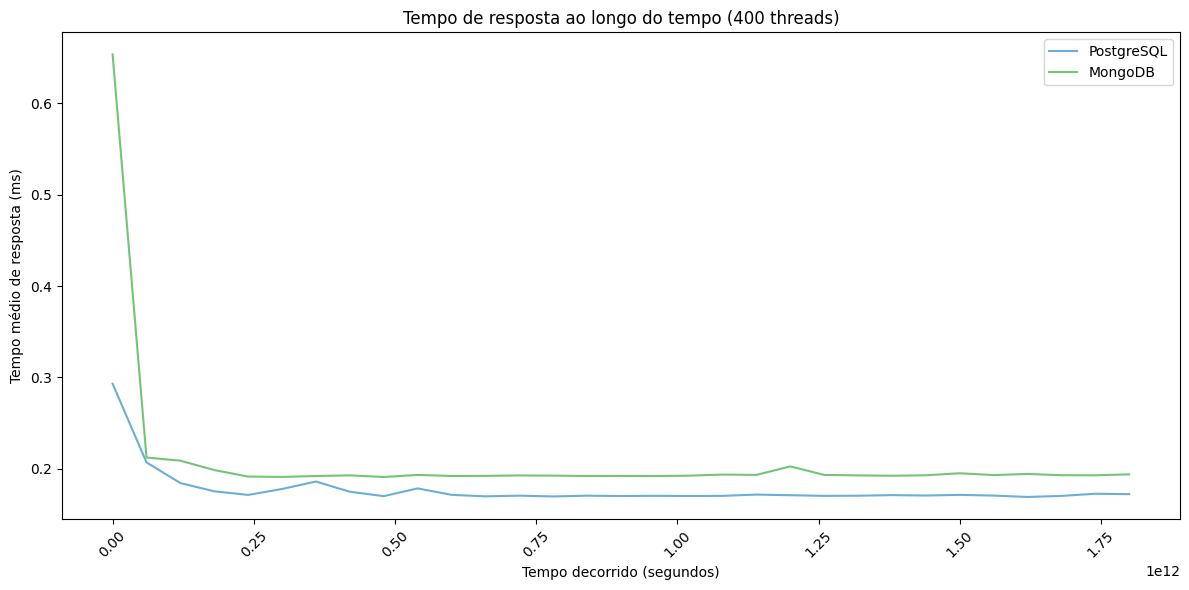

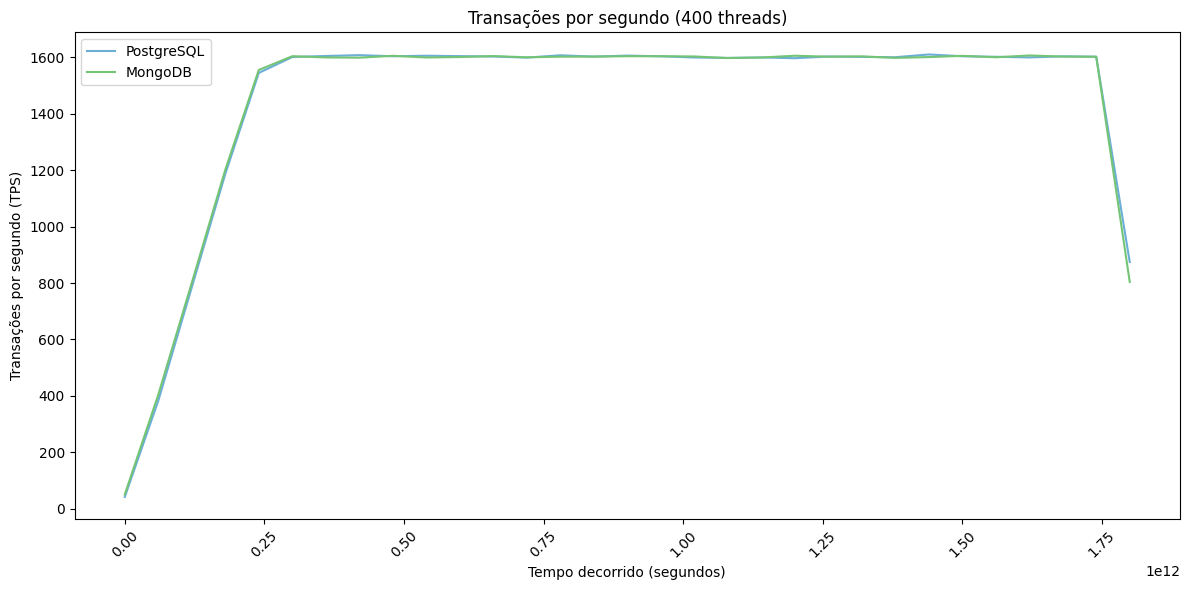

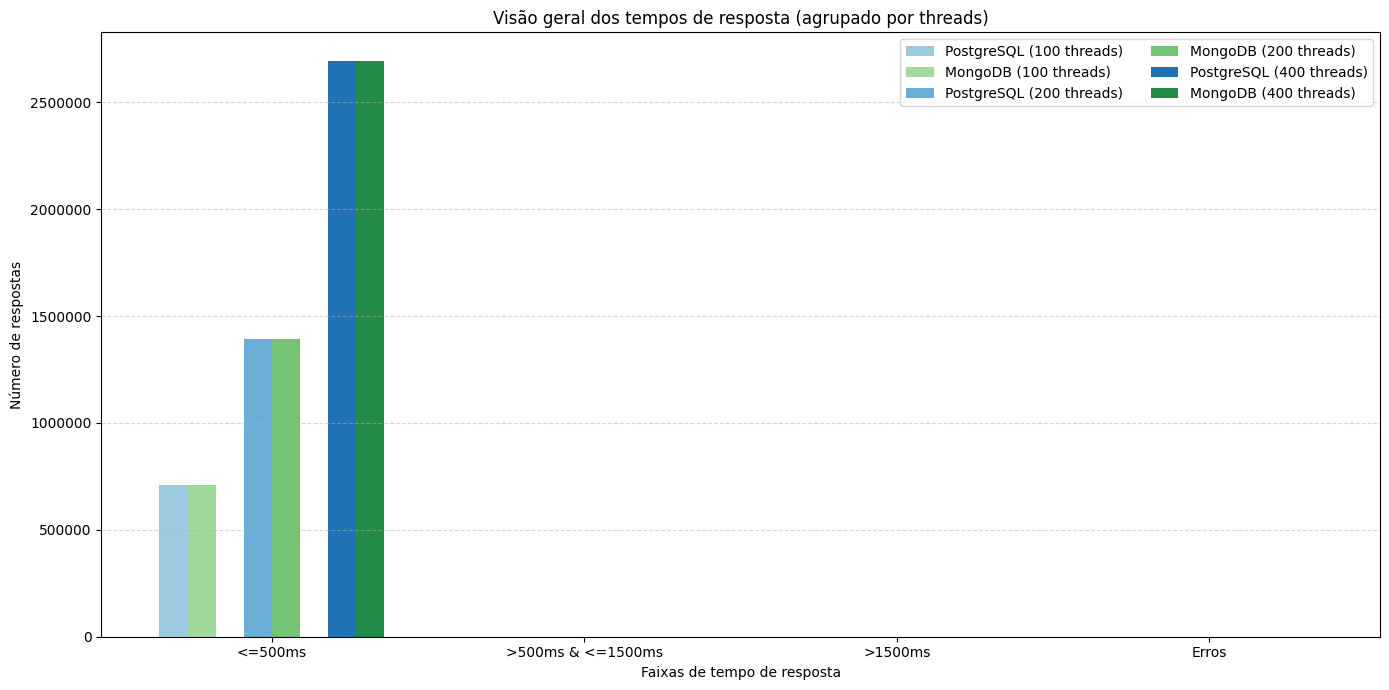

✅ Todos os gráficos foram salvos na pasta 'plots/'


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === PARÂMETROS ===
db_pg = 'pg'
db_mongo = 'mongo'
ramp = '240'
threads = '400'
workload = 'insert'

# === Paleta de cores ===
pg_color = '#6baed6'      # PostgreSQL - azul
mongo_color = '#74c476'   # MongoDB - verde

input_pg_file = f'output/{db_pg}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'
input_mongo_file = f'output/{db_mongo}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'

# === Diretório de saída ===
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# === Carregar dados ===
df_pg = pd.read_csv(input_pg_file)
df_mongo = pd.read_csv(input_mongo_file)

# === Converter timestamp ===
df_pg['timeStamp'] = pd.to_datetime(df_pg['timeStamp'], unit='ms')
df_mongo['timeStamp'] = pd.to_datetime(df_mongo['timeStamp'], unit='ms')

df_pg['ElapsedTime'] = (df_pg['timeStamp'] - df_pg['timeStamp'].iloc[0]).dt.total_seconds()
df_mongo['ElapsedTime'] = (df_mongo['timeStamp'] - df_mongo['timeStamp'].iloc[0]).dt.total_seconds()

# === Reamostrar ===
df_pg.set_index('timeStamp', inplace=True)
df_mongo.set_index('timeStamp', inplace=True)

response_pg = df_pg['elapsed'].resample('1T').mean()
response_mongo = df_mongo['elapsed'].resample('1T').mean()

tpm_pg = df_pg['elapsed'].resample('1T').count()
tpm_mongo = df_mongo['elapsed'].resample('1T').count()

tps_pg = tpm_pg / 60
tps_mongo = tpm_mongo / 60

# === Ajustar eixo de tempo ===
response_pg.index = (response_pg.index - response_pg.index[0])
response_mongo.index = (response_mongo.index - response_mongo.index[0])
tps_pg.index = (tps_pg.index - tps_pg.index[0])
tps_mongo.index = (tps_mongo.index - tps_mongo.index[0])

# === Nome dos arquivos ===
param_str = f"{ramp}_seconds_ramp_{threads}_threads_{workload}_workload"

# === Gráfico: Tempo de Resposta ao Longo do Tempo ===
plt.figure(figsize=(12, 6))
plt.plot(response_pg.index, response_pg.values, label='PostgreSQL', color=pg_color)
plt.plot(response_mongo.index, response_mongo.values, label='MongoDB', color=mongo_color)
plt.xlabel('Tempo decorrido (segundos)')
plt.ylabel('Tempo médio de resposta (ms)')
plt.title(f'Tempo de resposta ao longo do tempo ({threads} threads)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

filename_response_time = f'{output_dir}/tempo_resposta_ao_longo_do_tempo_{param_str}.png'
plt.savefig(filename_response_time, dpi=300)
plt.show()

# === Gráfico: Transações por Segundo (TPS) ===
plt.figure(figsize=(12, 6))
plt.plot(tps_pg.index, tps_pg.values, label='PostgreSQL', color=pg_color)
plt.plot(tps_mongo.index, tps_mongo.values, label='MongoDB', color=mongo_color)
plt.xlabel('Tempo decorrido (segundos)')
plt.ylabel('Transações por segundo (TPS)')
plt.title(f'Transações por segundo ({threads} threads)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

filename_tps = f'{output_dir}/transacoes_por_segundo_{param_str}.png'
plt.savefig(filename_tps, dpi=300)
plt.show()

# === Faixas de tempo de resposta ===
ranges = ['<=500ms', '>500ms & <=1500ms', '>1500ms', 'Erros']

def count_ranges(df):
    count_500 = len(df[df['elapsed'] <= 500])
    count_1500 = len(df[(df['elapsed'] > 500) & (df['elapsed'] <= 1500)])
    count_above = len(df[df['elapsed'] > 1500])
    count_errors = len(df[df['success'] == False]) if 'success' in df.columns else 0
    return [count_500, count_1500, count_above, count_errors]

# === Gráfico: Visão Geral dos Tempos de Resposta (Agrupado por Threads) ===
scenarios = {
    '100': '60',
    '200': '120',
    '400': '240'
}

response_data = {'PostgreSQL': {}, 'MongoDB': {}}

for threads, ramp in scenarios.items():
    file_pg = f'output/{db_pg}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'
    file_mongo = f'output/{db_mongo}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'

    df_pg = pd.read_csv(file_pg)
    df_mongo = pd.read_csv(file_mongo)

    if 'label' in df_mongo.columns:
        df_mongo = df_mongo[~df_mongo['label'].str.contains("database", case=False, na=False)]

    response_data['PostgreSQL'][threads] = count_ranges(df_pg)
    response_data['MongoDB'][threads] = count_ranges(df_mongo)

bar_width = 0.18
spacing = 2.0
thread_order = ['100', '200', '400']
x_base = np.arange(len(ranges)) * spacing

fig, ax = plt.subplots(figsize=(14, 7))

colors_pg = {'100': '#9ecae1', '200': '#6baed6', '400': '#2171b5'}
colors_mongo = {'100': '#a1d99b', '200': '#74c476', '400': '#238b45'}

for i, threads in enumerate(thread_order):
    offset = (i - 1) * bar_width * 3
    x_group = x_base + offset

    pg_vals = response_data['PostgreSQL'][threads]
    mongo_vals = response_data['MongoDB'][threads]

    ax.bar(x_group - bar_width/2, pg_vals, bar_width, label=f'PostgreSQL ({threads} threads)', color=colors_pg[threads])
    ax.bar(x_group + bar_width/2, mongo_vals, bar_width, label=f'MongoDB ({threads} threads)', color=colors_mongo[threads])

ax.set_xlabel('Faixas de tempo de resposta')
ax.set_ylabel('Número de respostas')
ax.set_title('Visão geral dos tempos de resposta (agrupado por threads)')
ax.set_xticks(x_base)
ax.set_xticklabels(ranges)
ax.legend(ncol=2)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig(f'{output_dir}/visao_geral_tempo_resposta_agrupado_threads.png', dpi=300)
plt.show()

print(f"✅ Todos os gráficos foram salvos na pasta '{output_dir}/'")
